In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Lambda, Input, Concatenate, Multiply, Subtract
from keras.regularizers import l2
from keras.utils import np_utils
from matplotlib import pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
num_classes = 4
img_size = 250
img_size_final = 64

In [3]:
def load_data():
    
    X = np.load('Lekhan/X_train.npy')
    Y = np.load('Lekhan/Y_train.npy')
    x = np.load('Lekhan/X_test.npy')
    y = np.load('Lekhan/Y_test.npy')
    X = X.reshape(X.shape[0], img_size, img_size, 1).astype('float32')
    x = x.reshape(x.shape[0], img_size, img_size, 1).astype('float32')
    X_mean = X.mean()
    X = (X - X_mean) / 127
    x = (x - X_mean) / 127
    Y = np_utils.to_categorical(Y, num_classes)
    y = np_utils.to_categorical(y, num_classes)
    X = X[:, :img_size_final, :img_size_final, :]
    x = x[:, :img_size_final, :img_size_final, :]
    return (X, Y), (x, y)

In [4]:
def make_pairs(X, Y):

    rx = []
    ry = []
    p = [[], [], [], []]
    for c in range(num_classes):
        for i in range(X.shape[0]):
            if Y[i][c] == 1:
                p[c].append(X[i])
        a = np.array(p[c] + p[c])
        b = a[np.random.permutation(range(a.shape[0]))]
        for i in range(a.shape[0]):
            rx.append([a[i], b[i]])
            ry.append([0, 1])
    sz = (2 * len(ry)) // (num_classes * (num_classes - 1))
    for i in range(num_classes):
        for j in range(i):
            a = np.array(p[i] + p[i])
            a = a[np.random.permutation(range(a.shape[0]))]
            b = np.array(p[j] + p[j])
            b = b[np.random.permutation(range(b.shape[0]))]
            for k in range(sz):
                rx.append([a[k], b[k]])
                ry.append([1, 0])
    return np.array(rx), np.array(ry)

In [5]:
def split_input(inputs):

    output1 = Lambda(lambda x : x[:, 0, :, :, :])(inputs)
    output2 = Lambda(lambda x : x[:, 1, :, :, :])(inputs)
    return output1, output2

In [6]:
conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')
conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')
drop1 = Dropout(0.25)
pool1 = MaxPooling2D(pool_size=(2, 2))
conv2_1 = Conv2D(64, (3, 3), activation='relu', padding='same')
conv2_2 = Conv2D(64, (3, 3), activation='relu', padding='same')
drop2 = Dropout(0.25)
pool2 = MaxPooling2D(pool_size=(2, 2))
conv3_1 = Conv2D(128, (3, 3), activation='relu', padding='same')
conv3_2 = Conv2D(128, (3, 3), activation='relu', padding='same')
drop3 = Dropout(0.25)
pool3 = MaxPooling2D(pool_size=(2, 2))
flat = Flatten()
dens = Dense(256, activation='relu')

def conv_siamese_net(inputs):

    x = conv1_1(inputs)
    x = conv1_2(x)
    x = drop1(x)
    x = pool1(x)
    x = conv2_1(x)
    x = conv2_2(x)
    x = drop2(x)
    x = pool2(x)
    x = conv3_1(x)
    x = conv3_2(x)
    x = drop3(x)
    x = pool3(x)
    x = flat(x)
    outputs = dens(x)
    return outputs

In [7]:
def concat(input1, input2):

    x1 = Concatenate()([input1, input2])
    t1 = Subtract()([input1, input2])
    t1 = Multiply()([t1, t1])
    t2 = Multiply()([input1, input2])
    x2 = Concatenate()([t1, t2])
    outputs = Concatenate()([x1, x2])
    return outputs

In [8]:
def fully_connected(inputs):

    x = Dropout(0.5)(inputs)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)
    return outputs

In [9]:
(X, Y), (x, y) = load_data()
Px, Py = make_pairs(X, Y)
px, py = make_pairs(x, y)

print(Px.shape)
print(Py.shape)
print(px.shape)
print(py.shape)

input_shape = (2, img_size_final, img_size_final, 1)

(2400, 2, 64, 64, 1)
(2400, 2)
(796, 2, 64, 64, 1)
(796, 2)


In [10]:
inputs = Input(shape=input_shape)
x1, x2 = split_input(inputs)
x1 = conv_siamese_net(x1)
x2 = conv_siamese_net(x2)
x = concat(x1, x2)
outputs = fully_connected(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 2, 64, 64, 1)  0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 64, 64, 1)     0           input_1[0][0]                    
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 64, 64, 1)     0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 64, 32)    320         lambda_1[0][0]                   
                                                                   lambda_2[0][0]          

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
hist = model.fit(Px, Py, batch_size=20, epochs=20, verbose=1, validation_data=(px, py))

Train on 2400 samples, validate on 796 samples
Epoch 1/20
2400/2400 [==============================] - 32s - loss: 0.6320 - acc: 0.6400 - val_loss: 0.5514 - val_acc: 0.7136
Epoch 2/20
2400/2400 [==============================] - 31s - loss: 0.5303 - acc: 0.7329 - val_loss: 0.5272 - val_acc: 0.7726
Epoch 3/20
2400/2400 [==============================] - 30s - loss: 0.4930 - acc: 0.7775 - val_loss: 0.4729 - val_acc: 0.7889
Epoch 4/20
2400/2400 [==============================] - 30s - loss: 0.4296 - acc: 0.8200 - val_loss: 0.5236 - val_acc: 0.8103
Epoch 5/20
2400/2400 [==============================] - 30s - loss: 0.3396 - acc: 0.8546 - val_loss: 0.3967 - val_acc: 0.8216
Epoch 6/20
2400/2400 [==============================] - 30s - loss: 0.2855 - acc: 0.8787 - val_loss: 0.3759 - val_acc: 0.8417
Epoch 7/20
2400/2400 [==============================] - 30s - loss: 0.2191 - acc: 0.9096 - val_loss: 0.5775 - val_acc: 0.7952
Epoch 8/20
2400/2400 [==============================] - 30s - loss: 0.2

In [13]:
score = model.evaluate(px, py, verbose=0)
print('Validation Loss : ', score[0])
print('Validation Accuracy : ', score[1])

Validation Loss :  0.216097809592
Validation Accuracy :  0.925879397584


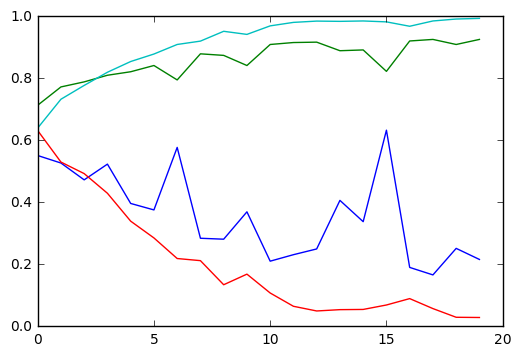

In [14]:
for key in hist.history.keys():
    plt.plot(hist.history[key])
plt.show()